<a href="https://colab.research.google.com/github/askuts/boots/blob/main/boost_tinkoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# задача с конкурса Tinkoff: https://boosters.pro/championship/tinkoff1/overview
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru.
# Необходимо предсказать, выберет ли покупатель кредит от Tinkoff.ru
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credit_tinkoff.csv', encoding='cp1251', sep=';')

In [ ]:
# смотрим на первые пять строк
data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [ ]:
#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133200 entries, 0 to 133199
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             133200 non-null  int64  
 1   gender                133200 non-null  object 
 2   age                   133197 non-null  float64
 3   marital_status        133197 non-null  object 
 4   job_position          133200 non-null  object 
 5   credit_sum            133198 non-null  object 
 6   credit_month          133200 non-null  int64  
 7   tariff_id             133200 non-null  float64
 8   score_shk             133193 non-null  object 
 9   education             133195 non-null  object 
 10  living_region         133047 non-null  object 
 11  monthly_income        133195 non-null  float64
 12  credit_count          126018 non-null  float64
 13  overdue_credit_count  126018 non-null  float64
 14  open_account_flg      133200 non-null  int64  
dtype

In [ ]:
#удаляем столбец с номером клиента (так как он незначимый)
# и с регионом проживания (так как он нуждается в серьезной предобработке)
data.drop(['client_id', 'living_region'], axis=1, inplace=True)

In [ ]:
# анализируем зависимую переменную: какие значения она принимает и сколько раз
data['open_account_flg'].value_counts(dropna=False)

0    109755
1     23445
Name: open_account_flg, dtype: int64

In [ ]:
# считаем, какая точность (доля правильных ответов) была бы у модели, если всем подряд пресказывать, что кредит они не выберут
d=140690/(140690+30056)
d

0.823972450306303

In [ ]:
# дозаполняем числовые столбцы с пропусками медианными значениями
data['age'].fillna(data['age'].median(), inplace=True)
data['credit_count'].fillna(data['credit_count'].median(), inplace=True)
data['overdue_credit_count'].fillna(data['overdue_credit_count'].median(), inplace=True)

In [ ]:
#меняем в столбцах 'credit_sum', 'score_shk'  запятые на точки  и преобразуем их в числовой  формат
for i in ['credit_sum', 'score_shk']:
    data[i] = data[i].str.replace(',', '.').astype('float')

In [ ]:
# дозаполняем ставшие теперь числовыми столбцы 'credit_sum', 'score_shk'   медианными значениями
data['score_shk'].fillna(data['score_shk'].median(), inplace=True)
data['monthly_income'].fillna(data['monthly_income'].median(), inplace=True)
data['credit_sum'].fillna(data['credit_sum'].median(), inplace=True)

In [ ]:
# смотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133200 entries, 0 to 133199
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                133200 non-null  object 
 1   age                   133200 non-null  float64
 2   marital_status        133197 non-null  object 
 3   job_position          133200 non-null  object 
 4   credit_sum            133200 non-null  float64
 5   credit_month          133200 non-null  int64  
 6   tariff_id             133200 non-null  float64
 7   score_shk             133200 non-null  float64
 8   education             133195 non-null  object 
 9   monthly_income        133200 non-null  float64
 10  credit_count          133200 non-null  float64
 11  overdue_credit_count  133200 non-null  float64
 12  open_account_flg      133200 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 13.2+ MB


In [ ]:
# кодируем пол методом факторизации
data['gender'] = pd.factorize(data['gender'])[0]


In [ ]:
# кодируем нечисловые столбцы методом дамми-кодирования
data = pd.concat([data,
                      pd.get_dummies(data['job_position'], prefix="job_position"),
                      pd.get_dummies(data['education'], prefix="education"),
                      pd.get_dummies(data['marital_status'], prefix="marital_status")],
                     axis=1)

In [ ]:
#удаляем старые нечисловые столбцы, вместо них уже появились новые числовые
data.drop(['job_position','education','marital_status'], axis=1, inplace=True)

In [ ]:
# Наша задача максимизировать значение ROC-AUC. Для этого будем использовать
# модель XGBoost

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Разделение данных на признаки и целевую переменную
X = data.drop('open_account_flg', axis=1)
y = data['open_account_flg']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели XGBoost
model = XGBClassifier()
model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Оценка модели с использованием метрик ROC-AUC и Accuracy
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, model.predict(X_test))

print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)

ROC-AUC: 0.757169761512535
Accuracy: 0.8298423423423423


In [ ]:
# Видим, что ROC-AUC равен 0.7572. Попробуем максимизировать значение
# путем использования GridSearch

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Разделение данных на признаки и целевую переменную
X = data.drop('open_account_flg', axis=1)
y = data['open_account_flg']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Поиск лучших параметров
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_

# Предсказание на тестовом наборе с лучшими параметрами
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Оценка модели с использованием метрик ROC-AUC и Accuracy
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, grid_search.predict(X_test))

print("Best Parameters:", best_params)
print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
ROC-AUC: 0.7629049631982061
Accuracy: 0.8310435435435436


In [ ]:
# Результат повысился, однако возможно мы можем улучшить результат брагодаря
# добавлению дополнительных критериев.

In [ ]:
# Разделение данных на признаки и целевую переменную
X = data.drop('open_account_flg', axis=1)
y = data['open_account_flg']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Поиск лучших параметров
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_

# Предсказание на тестовом наборе с лучшими параметрами
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Оценка модели с использованием метрик ROC-AUC и Accuracy
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, grid_search.predict(X_test))

print("Best Parameters:", best_params)
print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
ROC-AUC: 0.7626550243407725
Accuracy: 0.8305180180180181


In [ ]:
# Видим, что по сравнению с прошлой моделью результат ухудшился, что
# может быть связано с переобучением модели.


# Таким образом максимальное значение ROC-AUC полученное из предложенных
# моделей равно 0.7629.

# С помощью алгоритма XGBoost найдены следующие параметры, при которых метрика
# ROC-AUC принимает максимальные значения:

# learning_rate = 0.1
# max_depth = 3
# n_estimators = 200

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
ROC-AUC: 0.7591482740139779
Accuracy: 0.8307057057057057


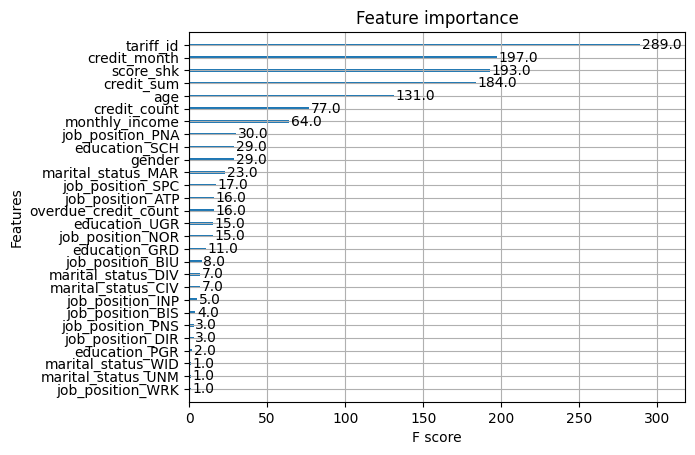

In [ ]:
# Далее визуализируем важности признаков модели
from xgboost import plot_importance

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Разделение данных на признаки и целевую переменную
X = data.drop('open_account_flg', axis=1)
y = data['open_account_flg']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost с лучшими параметрами
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
model = XGBClassifier(**best_params)

# Обучение модели XGBoost
model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Визуализация важности признаков
plot_importance(model)
plt.show()

In [ ]:
# Сумма кредита, внутренняя скоринговая оценка, срок кредитования и возраст
# имеют наибольшее влияние на вероятность выбора кредита Тинькоффом.

In [ ]:
# Также мы можем сделать бинарную регрессию для того, чтобы посмотреть как
# модель предсказывает бинарные значения.

In [ ]:
# Преобразование вероятностей в бинарные значения
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
# Оценка модели с использованием метрик ROC-AUC и Accuracy
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)

ROC-AUC: 0.5388698745542682
Accuracy: 0.8307057057057057


In [ ]:
# Видим, что ROC-AUC снизился значительно до 0.5388 по сравнению
# с максимальным значением. Это связано с тем, что мы фактически берем
# непрерывные вероятности и относите их к двум категориям (0 и 1), что в свою очередь
# может привести к потере информации.

In [ ]:
# Создаем DataFrame с фактическими и предсказанными значениями
comparison_df = pd.DataFrame({'Фактическое значение': y_test, 'Предсказанное значение': y_pred})

In [ ]:
comparison_df['Разница'] = comparison_df['Фактическое значение'] - comparison_df['Предсказанное значение']
comparison_df.head(10)

,Фактическое значение,Предсказанное значение,Разница
99636,0,0,0
76304,0,0,0
32533,0,0,0
7828,0,0,0
77730,0,0,0
78358,0,0,0
13137,1,1,0
11968,0,0,0
71078,0,0,0
5448,0,0,0
